## Part 3 - Supervised Learning: Generalisation & Overfitting; Decision trees.

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for now :

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) Using Decision Trees (on the training dataset only)

In [6]:
from sklearn.tree import DecisionTreeClassifier

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

dt_train = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt_train.fit(xtrain_images, y_train) 

predictions = dt_train.predict(x_train)

<function matplotlib.pyplot.show(close=None, block=None)>

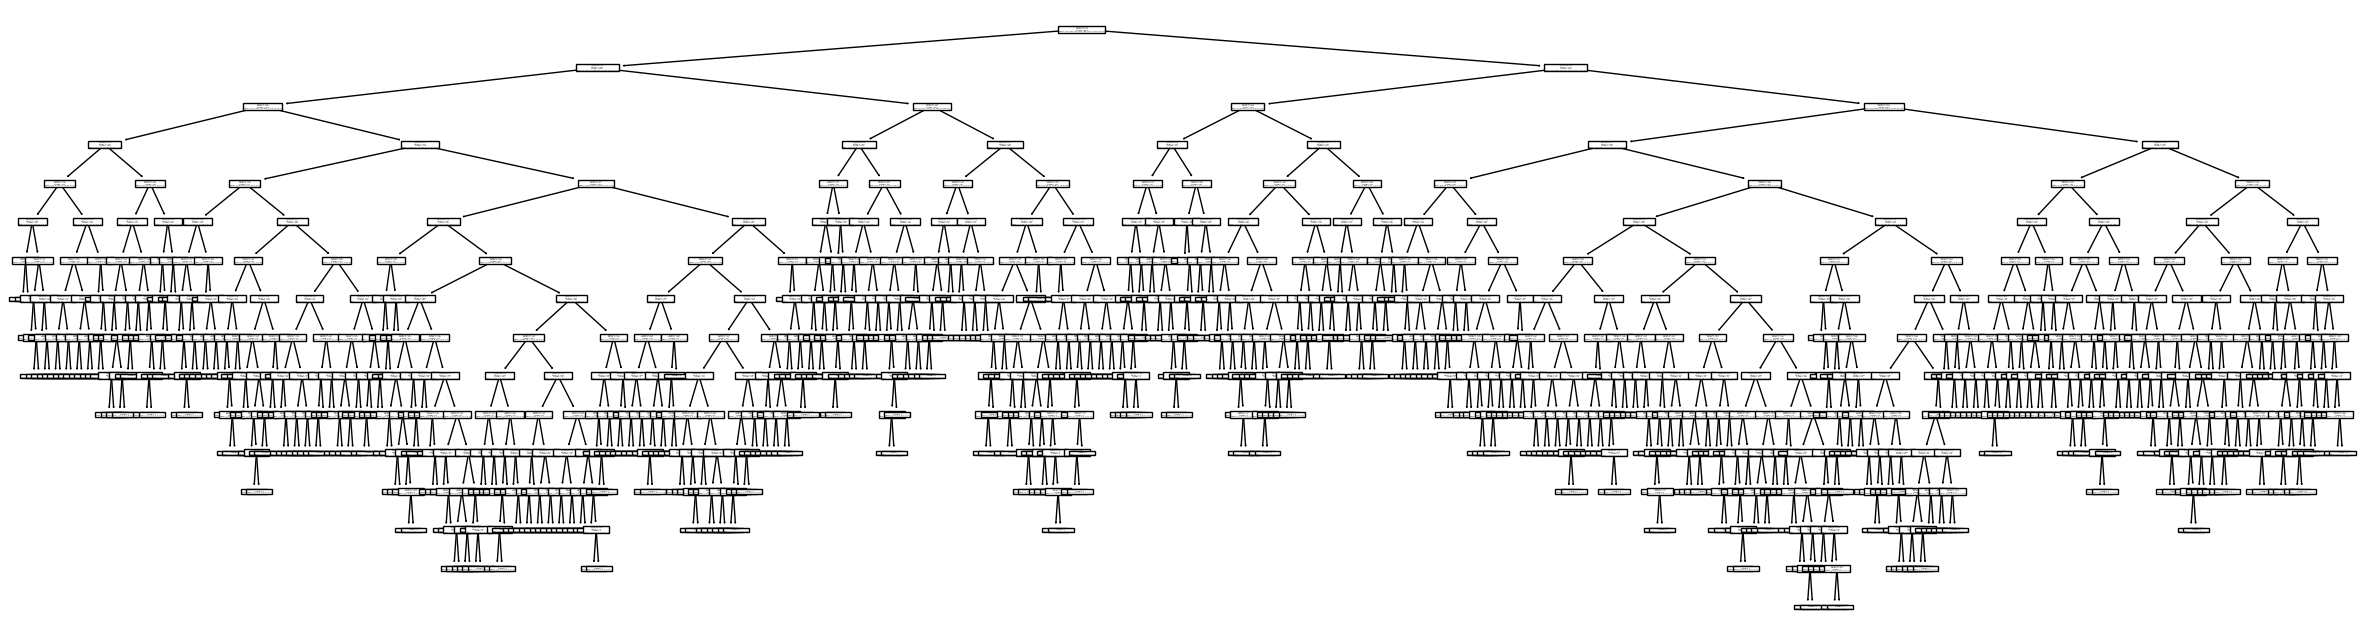

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 8))
plot_tree(dt_train)
plt.show

#### 1.1) Evaluation on training dataset

In [8]:
from sklearn.metrics import classification_report

report_train = classification_report(y_train, predictions)

print(report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690



In [9]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, predictions)
print('Accuracy on training dataset = ', accuracy_train)

Accuracy on training dataset =  1.0


In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train, predictions)
confusion_matrix_train

array([[ 210,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2220,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2250,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1410,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1980,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  210,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  360,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  240,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  540,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  270]],
      dtype=int64)

<Axes: >

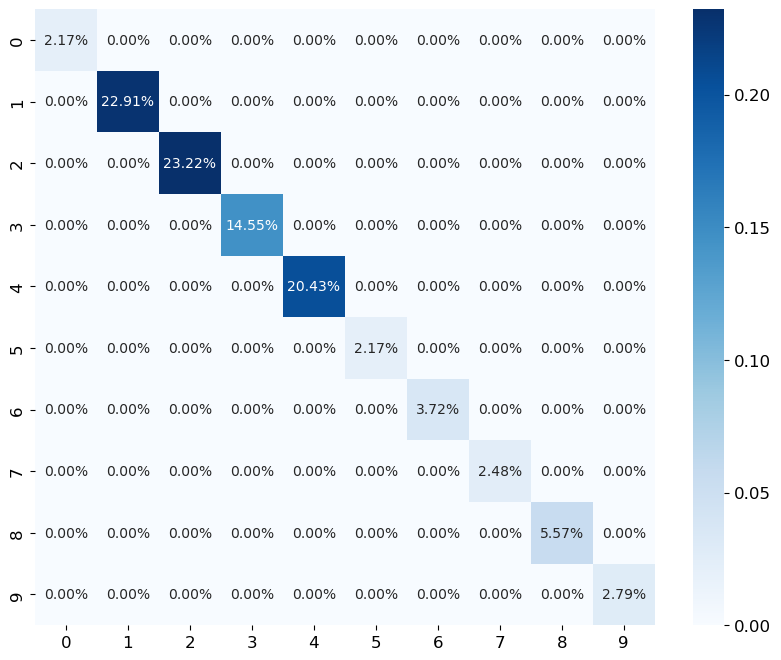

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score

def calculate_metrics_and_mean_train(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)

    result_df = pd.concat([result_df, auc_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [13]:
calculate_metrics_and_mean_train(x_train, y_train, predictions, dt_train)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


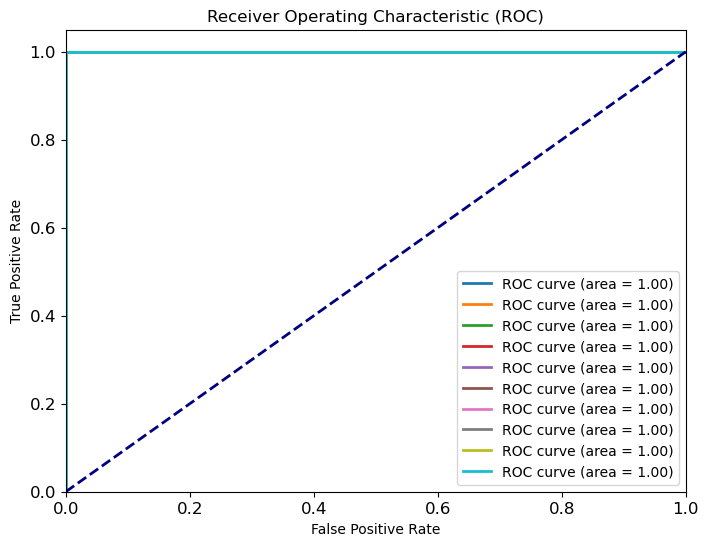

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_dt_train = dt_train.predict_proba(x_train)
roc_auc_scores_dt_train = []

plt.figure(figsize=(8, 6))
unique_labels_dt_train = np.unique(y_train)

for i in range(len(unique_labels_dt_train)):
    fpr_dt_train, tpr_dt_train, _ = roc_curve((y_train == unique_labels_dt_train[i]).astype(int), probabilities_dt_train[:, i])
    roc_auc_dt_train = auc(fpr_dt_train, tpr_dt_train)
    roc_auc_scores_dt_train.append(roc_auc_dt_train)
    plt.plot(fpr_dt_train, tpr_dt_train, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_dt_train))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 1.2) Cross Validation on train dataset

In [15]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [16]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.6130031  0.68833849 0.72033024 0.71826625 0.68833849 0.78018576
 0.64189886 0.77296182 0.71517028 0.74922601]
Mean: 0.7087719298245615
Standard deviation: 0.05059665136882167


In [17]:
scores1 = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=5)
display_scores(scores1)

Scores: [0.59855521 0.69762642 0.71878225 0.68421053 0.73477812]
Mean: 0.6867905056759545
Standard deviation: 0.04740426863923986


In [18]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
dt_train_nmse_scores = np.sqrt(-scores)
display_scores(dt_train_nmse_scores)

Scores: [1.93495893 1.5711538  1.41567227 1.59268192 1.78284452 1.48435251
 1.76918935 1.42112907 1.4899041  1.41348365]
Mean: 1.587537011409106
Standard deviation: 0.17315956612979827


### 2) Using Decision Trees (on the train and test datasets)

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc_curve(dt, x_test, y_test, resolution=199):
    probabilities_dt = dt.predict_proba(x_test)
    roc_auc_scores_dt = []

    plt.figure(figsize=(8, 6))
    unique_labels_dt = np.unique(y_train)

    for i in range(len(unique_labels_dt)):
        fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels_dt[i]).astype(int), probabilities_dt[:, i])
        roc_auc_dt = auc(fpr_dt, tpr_dt)
        roc_auc_scores_dt.append(roc_auc_dt)

        # Increase the resolution for smoother curves
        fpr_interp = np.interp(np.linspace(0, 1, resolution), fpr_dt, tpr_dt)
        plt.plot(np.linspace(0, 1, resolution), fpr_interp, lw=2, label=f'ROC curve (class {unique_labels_dt[i]}, area = {roc_auc_dt:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multiclass Decision Tree')
    plt.legend(loc='lower right')
    plt.show()

In [21]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt.fit(x_train, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42)

In [22]:
#X_pca.shape
x_test.shape

(3090, 2304)

In [23]:
"""
plt.figure(figsize=(30, 8))
plot_tree(dt)
plt.show
"""

'\nplt.figure(figsize=(30, 8))\nplot_tree(dt)\nplt.show\n'

In [24]:
y_pred = dt.predict(x_test)

calculate_metrics_and_mean(x_test, y_test, y_pred, dt)

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.412500,0.550000,0.471429,0.550000,0.015512,0.984488,0.550000,0.796454,0.726861,0.8411,0.016275
1,0.720050,0.793056,0.754792,0.793056,0.093671,0.906329,0.793056,0.796454,NaN,NaN,NaN
2,0.768309,0.769333,0.768821,0.769333,0.074359,0.925641,0.769333,0.796454,NaN,NaN,NaN
3,0.737705,0.700000,0.718358,0.700000,0.042424,0.957576,0.700000,0.796454,NaN,NaN,NaN
4,0.825083,0.757576,0.789889,0.757576,0.043621,0.956379,0.757576,0.796454,NaN,NaN,NaN
5,0.814815,0.733333,0.771930,0.733333,0.003300,0.996700,0.733333,0.796454,NaN,NaN,NaN
6,0.505376,0.522222,0.513661,0.522222,0.015333,0.984667,0.522222,0.796454,NaN,NaN,NaN
7,0.531250,0.283333,0.369565,0.283333,0.004950,0.995050,0.283333,0.796454,NaN,NaN,NaN
8,0.631579,0.640000,0.635762,0.640000,0.019048,0.980952,0.640000,0.796454,NaN,NaN,NaN
9,0.450980,0.511111,0.479167,0.511111,0.018667,0.981333,0.511111,0.796454,NaN,NaN,NaN


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


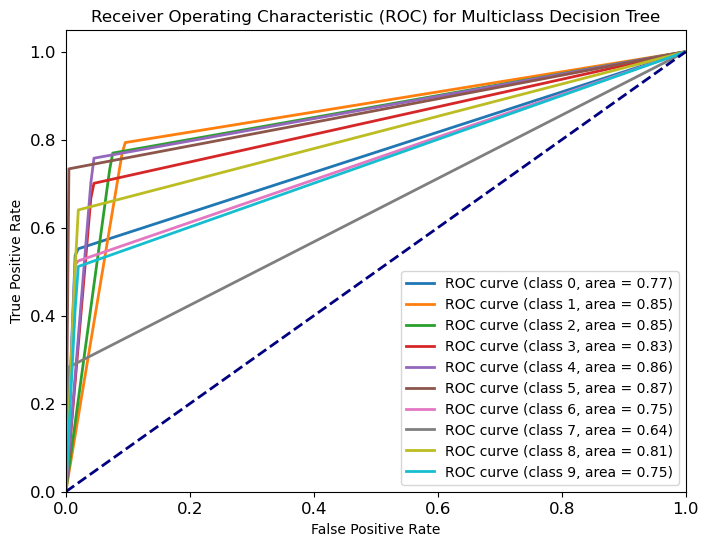

In [25]:
plot_multiclass_roc_curve (dt, x_test, y_test)

### Effect of parameters on Decision Tree

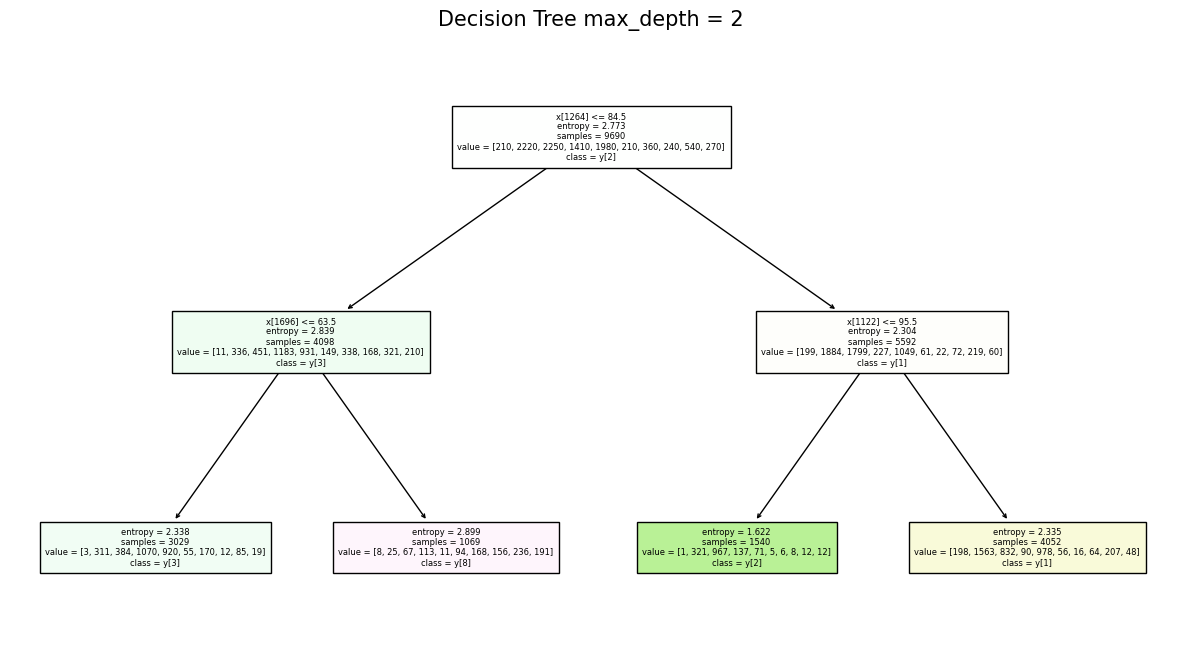

In [48]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

dt_train = DecisionTreeClassifier(max_depth=2,criterion='entropy',random_state=42)
dt_train.fit(xtrain_images, y_train) 
dt_train.predict(x_train[0:5])
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 8


tree.plot_tree(dt_train,class_names=True, filled=True, fontsize=6)
plt.title("Decision Tree max_depth = 2", fontsize= 15)
plt.show()


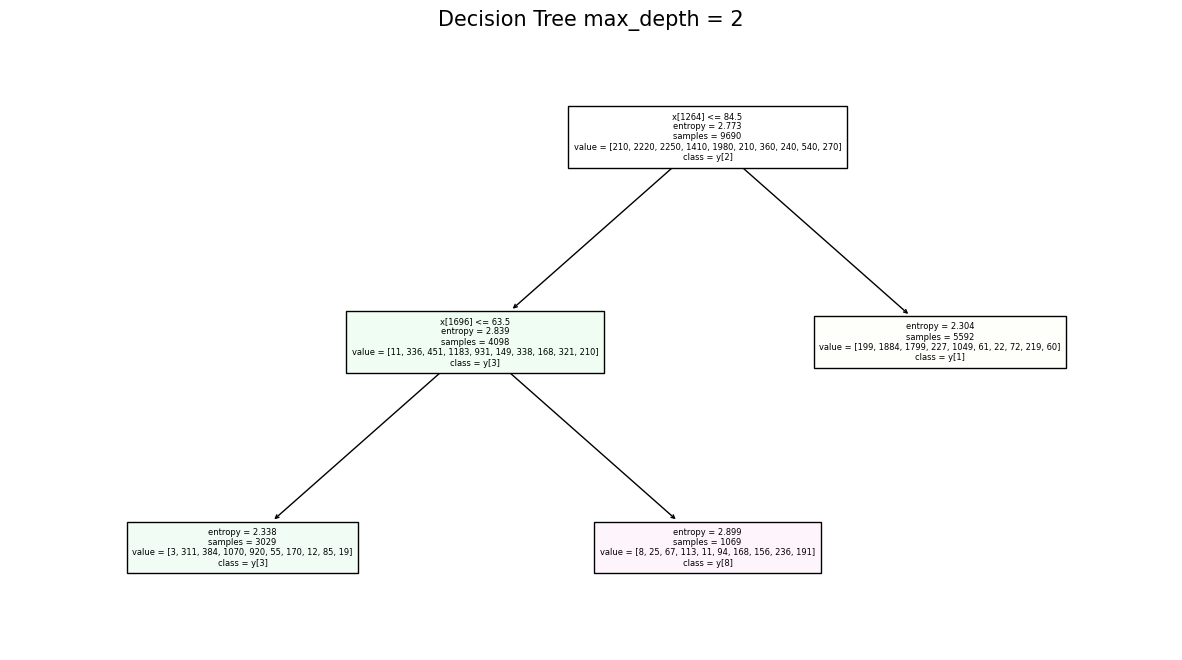

In [49]:
dt_train = DecisionTreeClassifier(max_depth=2,criterion='entropy',random_state=42, ccp_alpha= 0.1)
dt_train.fit(xtrain_images, y_train) 
dt_train.predict(x_train[0:5])
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 8


tree.plot_tree(dt_train,class_names=True, filled=True, fontsize=6)
plt.title("Decision Tree max_depth = 2", fontsize= 15)
plt.show()


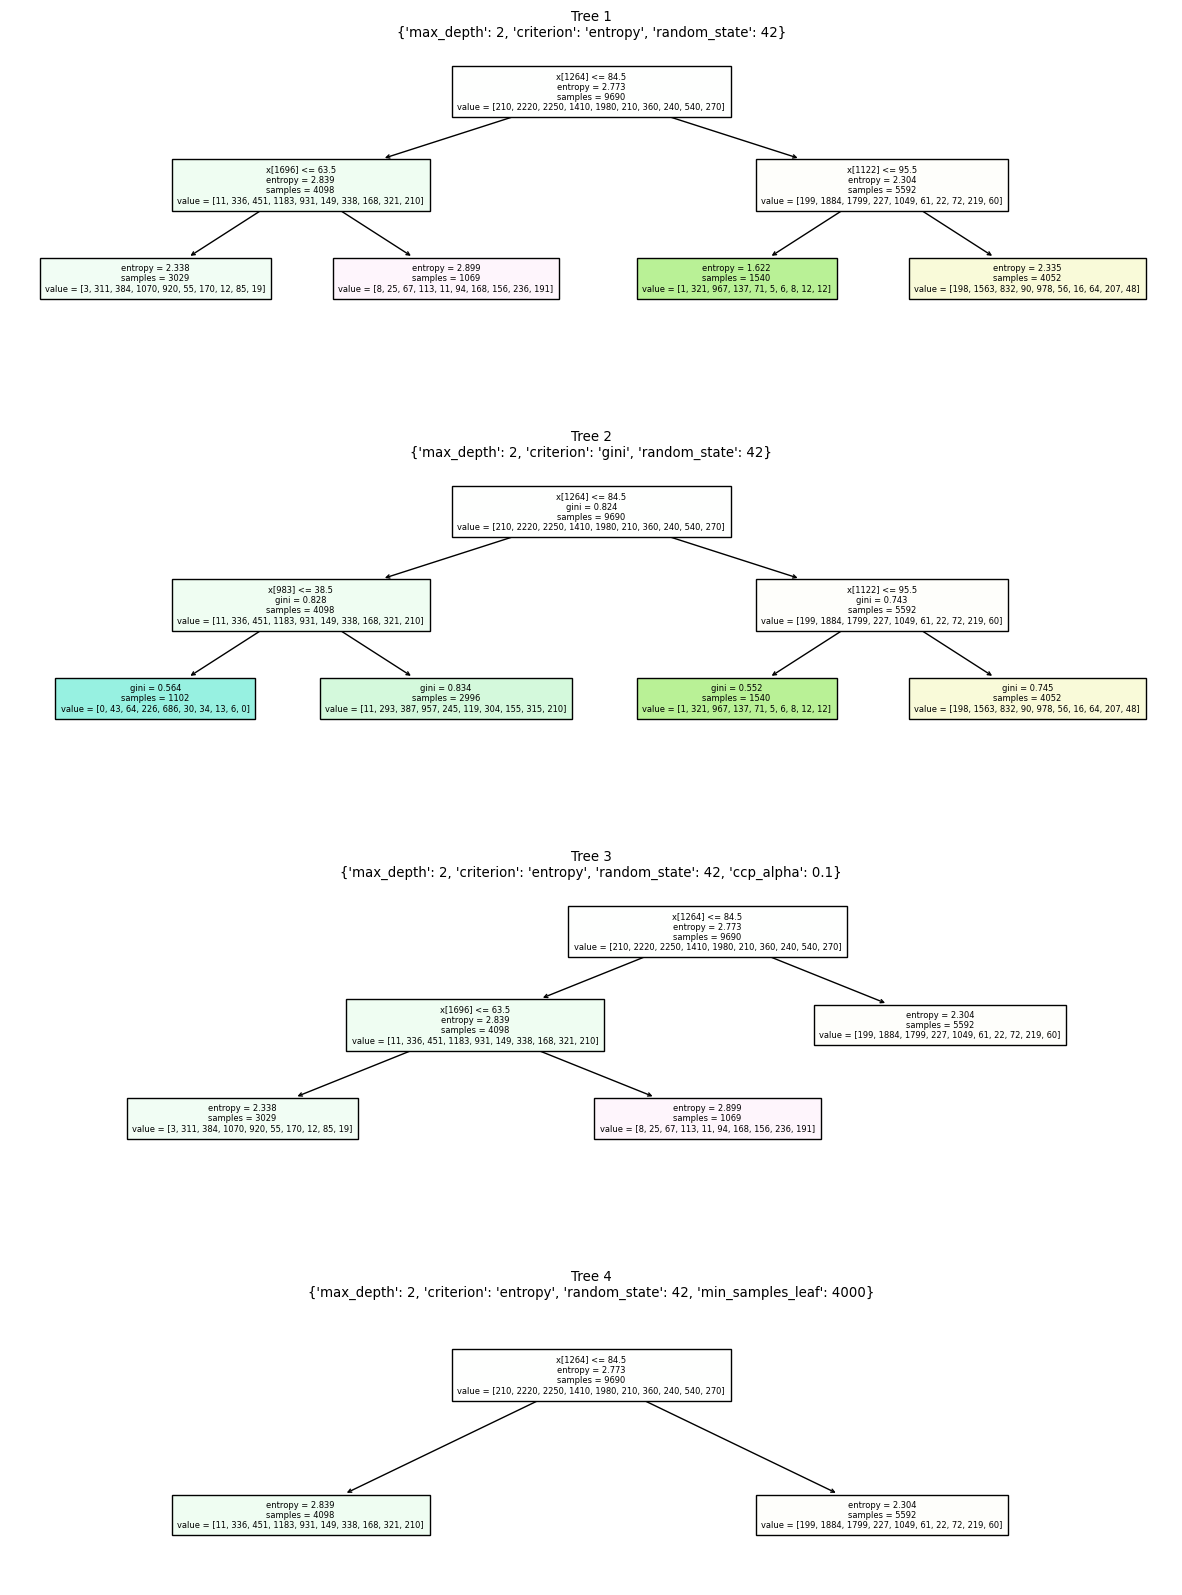

In [63]:
x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

hyperparameters = [
    {'max_depth': 2, 'criterion': 'entropy' , 'random_state':42},
    {'max_depth': 2, 'criterion': 'gini', 'random_state':42 },
    {'max_depth': 2, 'criterion': 'entropy', 'random_state':42,'ccp_alpha':0.1 },
    {'max_depth': 2, 'criterion': 'entropy', 'random_state':42, 'min_samples_leaf': 4000 },

]

fig, axes = plt.subplots(len(hyperparameters), 1, figsize=(15, 20))

for i, params in enumerate(hyperparameters):
    dt_train = DecisionTreeClassifier(**params)
    dt_train.fit(xtrain_images, y_train)
    plt.rcParams['font.size'] = 8
    tree.plot_tree(dt_train, filled=True, fontsize=6, ax=axes[i])
    axes[i].set_title(f"Tree {i + 1}\n{params}")

    
plt.subplots_adjust(hspace=0.5)
plt.show()

### 3) Experimenting with Decision Tree parameters

##### Reference : https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

#### 3.1) Changing Depth of the tree

#### Parameter tuning in the training dataset 


In [26]:
# Change in tree depth and accuracy
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def mean_cross_val_scores(model, x_train, y_train):
    scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)
    return scores.mean()

In [101]:
tree_depth = np.linspace(1, 20,20)
accuracy_scores = []
mean_cv_scores = []


In [102]:
print([int(x) for x in tree_depth])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [103]:
for i in tree_depth:
    clf = DecisionTreeClassifier(max_depth= int(i))
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf,x_train,y_train)
    mean_cv_scores.append(mean)


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Decis

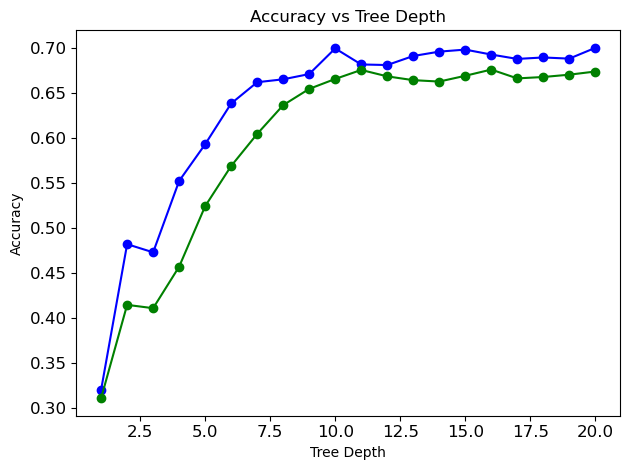

In [108]:
#plots

plt.plot(tree_depth, accuracy_scores, "bo-")
plt.plot(tree_depth, mean_cv_scores, "go-")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth")
plt.tight_layout()
plt.show()



In [110]:
accuracy_scores

[0.31974110032362457,
 0.4815533980582524,
 0.47249190938511326,
 0.551779935275081,
 0.5925566343042071,
 0.6378640776699029,
 0.6614886731391586,
 0.6647249190938511,
 0.6705501618122978,
 0.6990291262135923,
 0.6812297734627831,
 0.6805825242718446,
 0.6906148867313916,
 0.6954692556634304,
 0.6977346278317152,
 0.6922330097087379,
 0.6873786407766991,
 0.6889967637540453,
 0.6877022653721683,
 0.6996763754045308]

In [117]:
mean_cv_scores
#tree of size 16 gives best cross val score

[0.3104231166150671,
 0.41413828689370485,
 0.41042311661506703,
 0.45655314757481946,
 0.523735810113519,
 0.568421052631579,
 0.6040247678018575,
 0.636016511867905,
 0.6540763673890608,
 0.6651186790505677,
 0.6751289989680084,
 0.6680082559339524,
 0.6637770897832818,
 0.6622291021671827,
 0.6686274509803922,
 0.6755417956656347,
 0.6657378740970072,
 0.6672858617131062,
 0.6698658410732714,
 0.673374613003096]

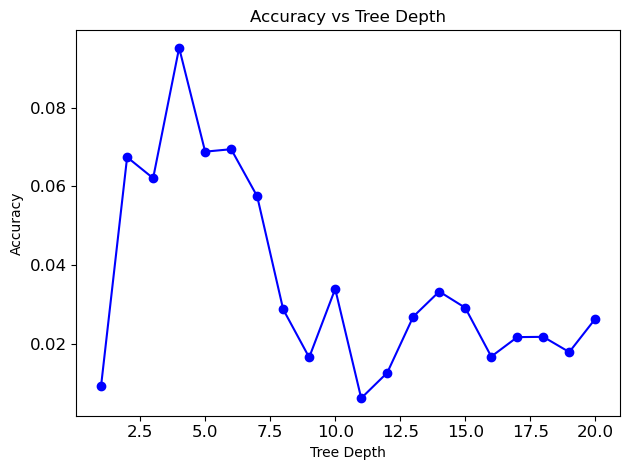

In [135]:
subtract_curves = []
for i in range(len(mean_cv_scores)):
    subtract_curves.append(accuracy_scores[i]- mean_cv_scores[i])

plt.plot(tree_depth, subtract_curves, "bo-")

plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth")
plt.tight_layout()
plt.show()


#### 3.2) Confidence threshold for pruning 

In [137]:
#ccp alpha 

ccp_alpha_list = [0.0, 0.01 ,0.02, 0.05 ,0.07, 0.1]
accuracy_score_alpha = []
cv_alpha = []

for alpha in ccp_alpha_list: 
        clf = DecisionTreeClassifier( max_depth=17, ccp_alpha=alpha )
        clf = clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        accuracy_score_alpha.append(metrics.accuracy_score(y_test,y_pred))
        mean = mean_cross_val_scores(clf, x_train, y_train)
        cv_alpha.append(mean)


        
    


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Decis

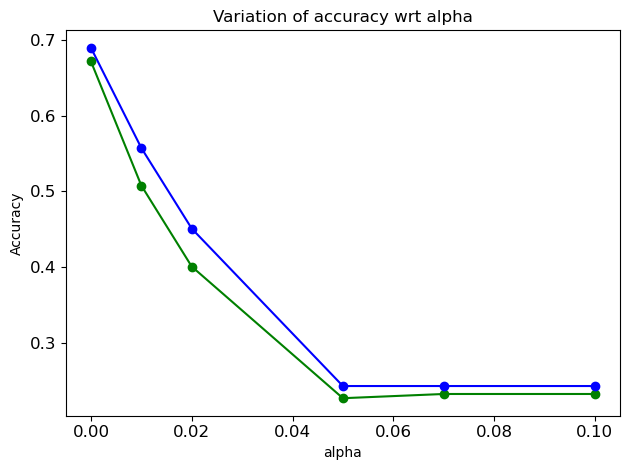

In [119]:
plt.plot(ccp_alpha_list, cv_alpha , "go-")
plt.plot(ccp_alpha_list, accuracy_score_alpha, "bo-")

plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Variation of accuracy wrt alpha")
plt.tight_layout()
plt.show()

#### 3.3) Splitting criteria 

In [54]:
splitting_nodes = [2,5,8]
accuracy_scores_nodes = []
cv_nodes = []

for node in splitting_nodes:
    clf = DecisionTreeClassifier(max_depth=17, min_samples_split=node)
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    accuracy_scores_nodes.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf,x_train,y_train)
    cv_nodes.append(mean)
  

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


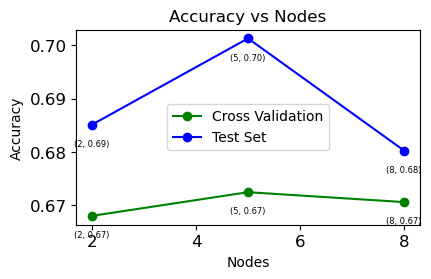

In [59]:
import matplotlib.pyplot as plt

def plot_hyperparameters(title, x_label, y_label, param_list, cross_val_list, testset_accuracies):
    plt.plot(param_list, cross_val_list, "go-", label="Cross Validation")
    plt.plot(param_list, testset_accuracies, "bo-", label="Test Set")
    
    for i, j, k in zip(param_list, cross_val_list, testset_accuracies):
        plt.annotate(f'({i}, {j:.2f})', xy=(i, j), xytext=(i, j-0.004 ), ha='center',fontsize= 6)
        plt.annotate(f'({i}, {k:.2f})', xy=(i, k), xytext=(i, k- 0.004), ha='center', fontsize= 6)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.show()



plt.figure(figsize=(8, 5))


plt.subplot(2,2,3)
plot_hyperparameters("Accuracy vs Nodes","Nodes","Accuracy",splitting_nodes, cv_nodes, accuracy_scores_nodes)




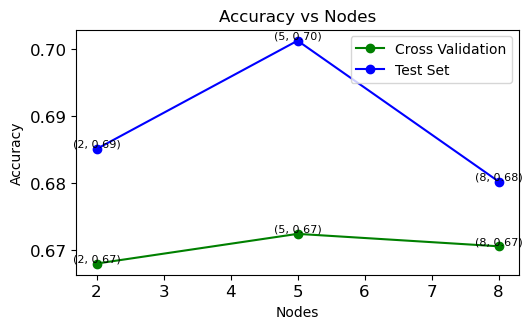

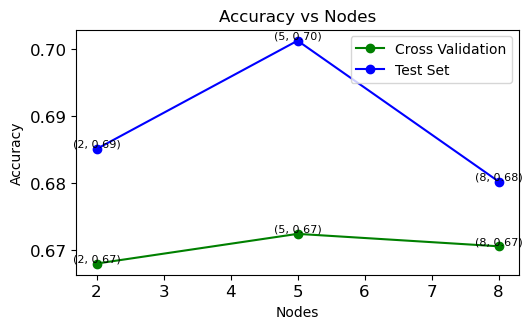

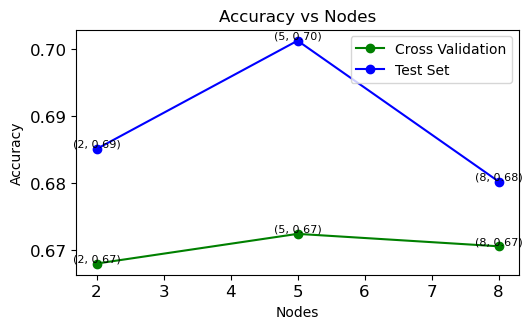

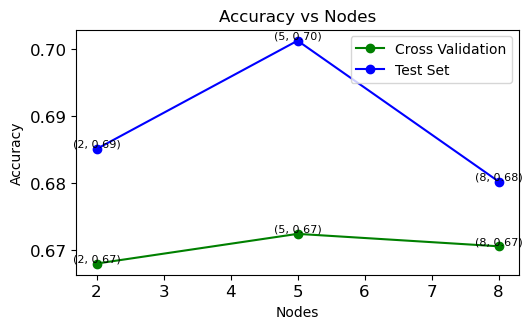

In [75]:
import matplotlib.pyplot as plt

def plot_coordinates(x_coor, y_coor):
    for x, y in zip(x_coor, y_coor):
        plt.text(x, y, f'({x}, {y:.2f})', ha='center', va='bottom', fontsize=8)

def plot_hyperparameters(title, x_label, y_label, param_list, cross_val_list, testset_accuracies):
    
    plt.plot(param_list, cross_val_list, "go-", label="Cross Validation")
    plt.plot(param_list, testset_accuracies, "bo-", label="Test Set")
    
    plot_coordinates(param_list, cross_val_list)
    plot_coordinates(param_list, testset_accuracies)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()




plt.figure(figsize=(10, 6))
plt.subplot(2,2,1)
plot_hyperparameters("Accuracy vs Tree Depth","Tree depth","Accuracy",tree_depth, mean_cv_scores, accuracy_scores)



plt.figure(figsize=(10, 6))
plt.subplot(2,2,2)
plot_hyperparameters("Accuracy vs Alpha","Alpha","Accuracy",ccp_alpha_list, cv_alpha, accuracy_score_alpha)



plt.figure(figsize=(10, 6))
plt.subplot(2,2,3)
plot_hyperparameters("Accuracy vs Nodes", "Nodes", "Accuracy", splitting_nodes, cv_nodes, accuracy_scores_nodes)



plt.figure(figsize=(10, 6))
plt.subplot(2,2,4)
plot_hyperparameters("Accuracy vs Leaves","leaves","Accuracy",leaf, cv_leaf, accuracy_score_leafs)





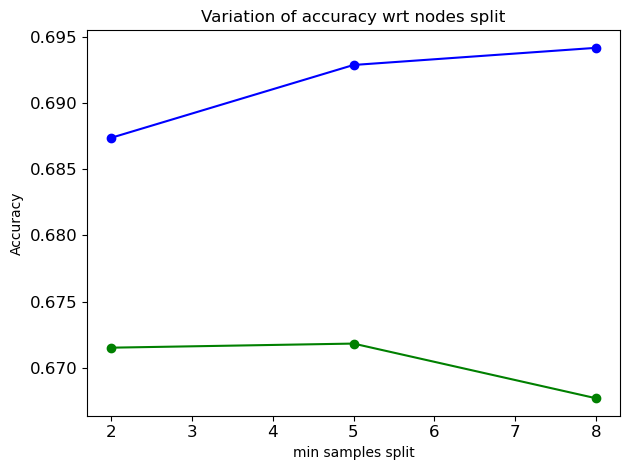

In [32]:
plt.plot(splitting_nodes, cv_nodes , "go-")
plt.plot(splitting_nodes, accuracy_scores_nodes, "bo-")



plt.xlabel("min samples split")
plt.ylabel("Accuracy")
plt.title("Variation of accuracy wrt nodes split")
plt.tight_layout()
plt.show()

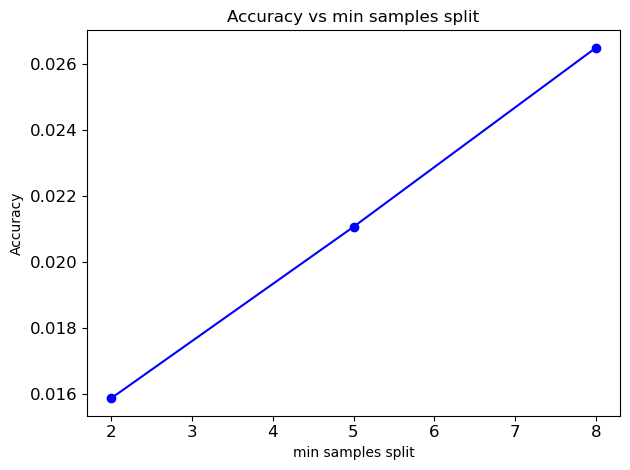

In [34]:
subtract_curves = []
for i in range(len(cv_nodes)):
    subtract_curves.append(accuracy_scores_nodes[i]- cv_nodes[i])

plt.plot(splitting_nodes, subtract_curves, "bo-")

plt.xlabel("min samples split")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min samples split")
plt.tight_layout()
plt.show()


#### 3.4) Mininum number of instances permissible per leaf

In [129]:
leaf = np.linspace(1, 20, 10)
cv_leaf = []
accuracy_score_leafs = []

for i in leaf:
    clf = DecisionTreeClassifier( max_depth=17, min_samples_leaf = int(i))
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    accuracy_score_leafs.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf, x_train, y_train)

    
    cv_leaf.append(mean)

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Decis

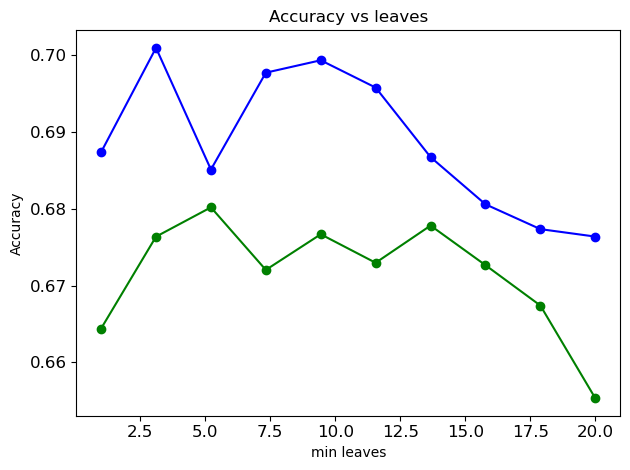

In [130]:



plt.plot(leaf, cv_leaf , "go-")
plt.plot(leaf, accuracy_score_leafs, "bo-")
#plt.plot(leaf, training_scores, "r+")

plt.xlabel("min leaves")
plt.ylabel("Accuracy")
plt.title("Accuracy vs leaves")
plt.tight_layout()
plt.show()

In [125]:
print([int(x) for x in leaf])

[1, 3, 5, 7, 9, 11, 13, 15, 17, 20]


In [150]:

optimised_dt = DecisionTreeClassifier(max_depth=5,min_samples_leaf=8,min_samples_split=5,ccp_alpha=1
                                      )
optimised_dt = dt.fit(x_train,y_train)
y_pred_train = dt.predict(x_train)
y_pred_test = dt.predict(x_test)

accuracy_score(y_train,y_pred_train)
#
# accuracy_score(y_test, y_pred_test)

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


1.0

In [153]:
#run if u want ,, its going to take ages

from sklearn.model_selection import GridSearchCV

#Paramters to run 
params = {
    'max_depth': [5,10,17], 
    'min_samples_split': [2,5,8],
    'min_samples_leaf' : [5,13],
   

}


gridSearch = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=10,
    scoring='accuracy',
    n_jobs=-1 )

# Fit the GridSearchCV object to the data
gridSearch.fit(x_train, y_train)

# Get the best parameters
best_parameters = gridSearch.best_params_

# Get the best score
best_cross_val_score = gridSearch.best_score_


print(best_parameters)
print(best_cross_val_score)



{'max_depth': 17, 'min_samples_leaf': 13, 'min_samples_split': 2}
0.6785345717234262


In [24]:
#run if u want ,, its going to take ages

from sklearn.model_selection import GridSearchCV

#Paramters to run 
params = {
    'max_depth': [1,5,10,16,17], 
    'criterion' : ['gini','entropy'],
    'min_samples_split': [2,5,8,10],
    'min_samples_leaf' : [5,7,9,10],
    'ccp_alpha' : [0.0,0.01,0.02,0.05]
    

}


gridSearch = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=10,
    scoring='accuracy',
    n_jobs=-1 )

# Fit the GridSearchCV object to the data
gridSearch.fit(x_train, y_train)

# Get the best parameters
best_parameters = gridSearch.best_params_

# Get the best score
best_cross_val_score = gridSearch.best_score_


print(best_parameters)
print(best_cross_val_score)



{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.7157894736842104


In [ ]:
gridSearch.

#### rubbish down here

In [ ]:
# Change in tree depth and accuracy 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

tree_depth = range(1,20)
accuracy_scores = []
mean_cv_scores = []

def mean_cross_val_scores(model, x_train, y_train):
    scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)
    return scores.mean()

for i in tree_depth: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test,y_pred))
    
    #scores = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=10)
    #mean_cross_val_scores.append(scores.mean())

    #mean = mean_cross_val_scores(clf,x_train,y_train)
    #mean_cv_scores.append(mean)
    print("======================================================================")
    print("tree depth =", i)
    print()
    print(classification_report(y_test, y_pred, output_dict=True,zero_division=0))
    print()
    print("======================================================================")

    

    



In [ ]:
#plots 


plt.plot(tree_depth, accuracy_scores, "bo-")
#plt.plot(tree_depth, mean_cv_scores, "go-")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth")
plt.tight_layout()
plt.show()


In [ ]:
accuracy_list = [x*100 for x in accuracy_scores]
print(accuracy_list)
print(max(accuracy_list))
print(accuracy_list.index(max(accuracy_list)))

In [69]:
from sklearn.model_selection import GridSearchCV

#Paramters to run 
params = {

}


gridSearch = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=10,
    scoring='accuracy',
    n_jobs=-1 )

# Fit the GridSearchCV object to the data
gridSearch.fit(x_train, y_train)

# Get the best parameters
best_parameters = gridSearch.best_params_

# Get the best score
best_cross_val_score = gridSearch.best_score_


print(best_parameters)
print(best_cross_val_score)



KeyboardInterrupt: 

In [ ]:
# Train a DecisionTreeClassifier with the best parameters
best_clf = DecisionTreeClassifier(random_state=42, **best_params)
best_clf.fit(x_train, y_train)

# Use the model to make predictions on the test set
y_pred_best = best_clf.predict(x_test)

# Calculate accuracy on the test set
accuracy_best = accuracy_score(y_test, y_pred_best)

# Calculate classification report for precision, recall, f1-score and support
report_best = classification_report(y_test, y_pred_best)

# best_params, best_score, accuracy_best, report_best

print(best_params)
print(best_score)
print(accuracy_best)
print(report_best)

In [ ]:
"""

#dont even bother running this, it will finish when i die

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)


train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]



fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

"""